In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torch.optim as optim

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Load

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5,))])

In [8]:
trainset = datasets.FashionMNIST(root='./',
                                 train=True,
                                 download=True,
                                 transform=transform)

testset = datasets.FashionMNIST(root='./',
                                train=False,
                                download=True,
                                transform=transform,
                                )

100%|██████████| 26421880/26421880 [00:04<00:00, 5382184.53it/s]


Extracting ./FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 108642.03it/s]


Extracting ./FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1709618.90it/s]


Extracting ./FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\raw



In [9]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [10]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [11]:
labels_map = {
    0 : 'T-Shirt',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9: 'Ankle Boot',
}

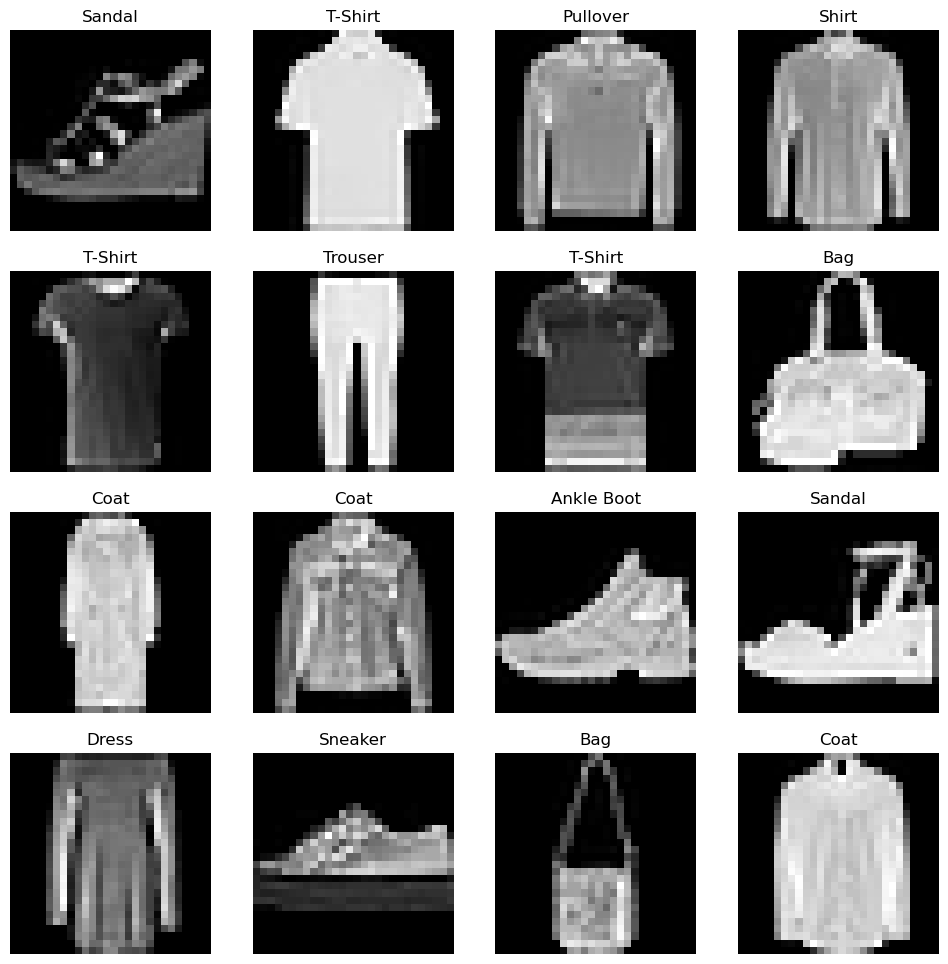

In [13]:
figure = plt.figure(figsize=(12, 12))
cols, rows = 4,4

for i in range(1, cols * rows + 1):
    image = images[i].squeeze()
    label_idx = labels[i].item()
    label = labels_map[label_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()

## Define Model & Parameter

In [25]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s

        return num_features
    
net = NeuralNet()
print(net)

NeuralNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [26]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [27]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[-0.0913,  0.0317, -0.0483, -0.0514,  0.0610, -0.0811,  0.0342, -0.0676,
          0.0682, -0.0614]], grad_fn=<AddmmBackward0>)


## Loss Function Optimizer

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

## Model Training

In [31]:
total_batch = len(train_loader)
total_batch

469

In [32]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print('Epoch: {}, Iter : {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter : 100, Loss: 0.11484884691238403
Epoch: 1, Iter : 200, Loss: 0.11392210364341736
Epoch: 1, Iter : 300, Loss: 0.11121439671516418
Epoch: 1, Iter : 400, Loss: 0.10205252367258072
Epoch: 2, Iter : 100, Loss: 0.05338938635587692
Epoch: 2, Iter : 200, Loss: 0.043278798013925555
Epoch: 2, Iter : 300, Loss: 0.03893525695800781
Epoch: 2, Iter : 400, Loss: 0.03780580016970635
Epoch: 3, Iter : 100, Loss: 0.0349305734038353
Epoch: 3, Iter : 200, Loss: 0.034397498667240144
Epoch: 3, Iter : 300, Loss: 0.0345530991256237
Epoch: 3, Iter : 400, Loss: 0.03380177690088749
Epoch: 4, Iter : 100, Loss: 0.03246734811365604
Epoch: 4, Iter : 200, Loss: 0.0318676435649395
Epoch: 4, Iter : 300, Loss: 0.03171812385320663
Epoch: 4, Iter : 400, Loss: 0.03133154009282589
Epoch: 5, Iter : 100, Loss: 0.031032213777303697
Epoch: 5, Iter : 200, Loss: 0.03058001583814621
Epoch: 5, Iter : 300, Loss: 0.029840496942400933
Epoch: 5, Iter : 400, Loss: 0.028900640040636062
Epoch: 6, Iter : 100, Loss: 0.02890972

## Model Save & Load

- **<span style="color:pink">torch.save</span>** : net.state_dict()로 모델 저장
- **<span style="color:pink">torch.load</span>** : load_state_dict() 로 모델 로드

In [33]:
path = './fashion_mnist.pth'
torch.save(net.state_dict(),path)

In [34]:
net = NeuralNet()
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [35]:
net.parameters

<bound method Module.parameters of NeuralNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

## Model Test

In [36]:
def imshow(image):
    image = image / 2 + 0.5
    npimg = image.numpy()

    fig = plt.figure(figsize=(16,8))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

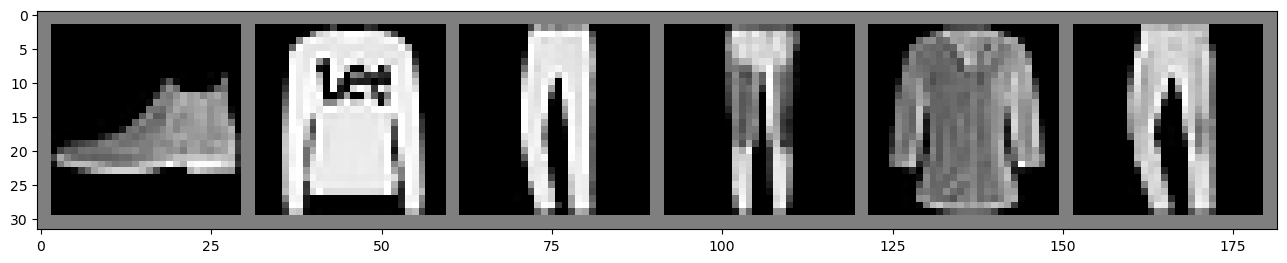

In [38]:
import torchvision

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:6]))

In [39]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 6, 8, 0, 2, 7, 7, 5,
        1, 6, 6, 3, 9, 4, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 3, 9, 6, 7, 2, 1,
        2, 6, 4, 6, 5, 8, 4, 2, 8, 6, 8, 0, 7, 7, 8, 5, 1, 1, 0, 4, 7, 8, 7, 0,
        2, 6, 4, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 2, 5, 3, 6, 7, 1, 8,
        0, 1, 4, 2, 3, 4, 7, 3, 7, 8, 5, 7, 9, 4, 6, 5, 7, 0, 5, 2, 8, 4, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4])


In [40]:
print(''.join('{}, '.format(labels_map[int(predicted[j].numpy())]) for j in range(6)))

Ankle Boot, Pullover, Trouser, Trouser, Shirt, Trouser, 


In [41]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(100 * correct /total)

80.75
